In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
with open("r&m.txt", "r", encoding="utf-8") as f:
    text = f.read()

In [3]:
chars = sorted(list(set(text)))    # vocab build
vocab_size = len(chars)
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}
encode = lambda s: [stoi.get(c, 0) for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

In [4]:
data = torch.tensor(encode(text), dtype=torch.long)  # encode dataset
train_data = data[:int(0.9 * len(data))]
val_data = data[int(0.9 * len(data)):]

In [5]:
batch_size = 32        #hyperparameters for the transformer layer
block_size = 128
n_embd = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'
learning_rate = 1e-3
max_iters = 5000
eval_interval = 250


In [6]:
def get_batch(split):            # batch loader
    d = train_data if split == 'train' else val_data
    ix = torch.randint(len(d) - block_size, (batch_size,))
    x = torch.stack([d[i:i+block_size] for i in ix])
    y = torch.stack([d[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

In [7]:
class TransformerBlock(nn.Module):
    def __init__(self, n_embd, num_heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(n_embd, num_heads, dropout=0.1, batch_first=True)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ff = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd)
        )
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, attn_mask=None):
        x = x + self.attn(self.ln1(x), self.ln1(x), self.ln1(x), attn_mask=attn_mask)[0]
        x = x + self.ff(self.ln2(x))
        return x


In [8]:
class Transformer(nn.Module):
    def __init__(self, vocab_size, n_embd, block_size, num_layers=2, num_heads=4):
        super().__init__()
        self.token_emb = nn.Embedding(vocab_size, n_embd)
        self.pos_emb = nn.Embedding(block_size, n_embd)
        self.blocks = nn.ModuleList([
            TransformerBlock(n_embd, num_heads) for _ in range(num_layers)
        ])
        self.ln_f = nn.LayerNorm(n_embd)
        self.head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_emb(idx)
        pos_emb = self.pos_emb(torch.arange(T, device=idx.device))
        x = tok_emb + pos_emb

        mask = torch.tril(torch.ones(T, T, device=idx.device)).bool()
        attn_mask = ~mask

        for block in self.blocks:
            x = block(x, attn_mask=attn_mask)

        x = self.ln_f(x)
        logits = self.head(x)

        loss = None
        if targets is not None:
            B, T, C = logits.shape
            loss = F.cross_entropy(logits.view(B * T, C), targets.view(B * T))

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx


In [9]:
model = Transformer(vocab_size, n_embd, block_size, num_layers=2, num_heads=4).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for step in range(max_iters):
    xb, yb = get_batch('train')
    logits, loss = model(xb, yb)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if step % eval_interval == 0:
        val_loss = 0
        with torch.no_grad():
            for _ in range(10):
                xval, yval = get_batch('val')
                _, vloss = model(xval, yval)
                val_loss += vloss.item()
            val_loss /= 10
        train_losses.append(loss.item())
        val_losses.append(val_loss)
        print(f"Step {step}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")


Step 0, Train Loss: 4.6186, Val Loss: 4.2832
Step 250, Train Loss: 2.3544, Val Loss: 2.4379
Step 500, Train Loss: 1.9868, Val Loss: 2.1005
Step 750, Train Loss: 1.8952, Val Loss: 1.9598
Step 1000, Train Loss: 1.7513, Val Loss: 1.8380
Step 1250, Train Loss: 1.6864, Val Loss: 1.8013
Step 1500, Train Loss: 1.6844, Val Loss: 1.7284
Step 1750, Train Loss: 1.6073, Val Loss: 1.7248
Step 2000, Train Loss: 1.6172, Val Loss: 1.6523
Step 2250, Train Loss: 1.5814, Val Loss: 1.6444
Step 2500, Train Loss: 1.4961, Val Loss: 1.6415
Step 2750, Train Loss: 1.4938, Val Loss: 1.6129
Step 3000, Train Loss: 1.4508, Val Loss: 1.6174
Step 3250, Train Loss: 1.4670, Val Loss: 1.6159
Step 3500, Train Loss: 1.4325, Val Loss: 1.6052
Step 3750, Train Loss: 1.4300, Val Loss: 1.5964
Step 4000, Train Loss: 1.3988, Val Loss: 1.5837
Step 4250, Train Loss: 1.3834, Val Loss: 1.5803
Step 4500, Train Loss: 1.3345, Val Loss: 1.5635
Step 4750, Train Loss: 1.3937, Val Loss: 1.5703


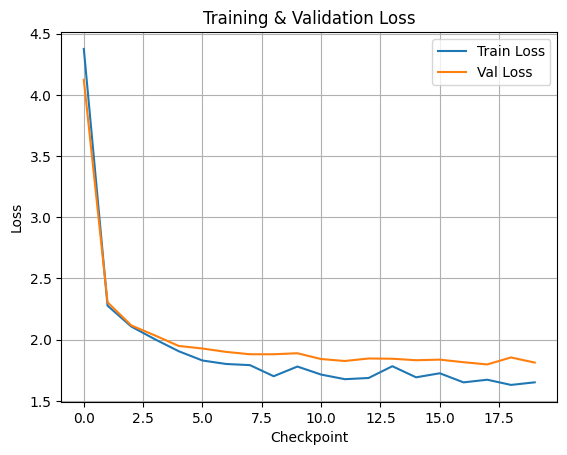

In [40]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Checkpoint')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [41]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated = model.generate(context, max_new_tokens=500, temperature=0.7, top_k=50)
print(decode(generated[0].tolist()))


Hey! Nobom this port a the make the stis bunchest tyou that's be the be a could hero.
It's want it.
- Oh, it's the robit.
It's love pandance that are there, too me to an Can yoou thina thing me to adammer.
What's thing seing I am to bamuer are an that the schooes to be a get are inside? That's and just areal ther! Where's deah.
My mean I son they chan whole foor a pirant there's you re to thing on even camination.
I'm the miss.
Can "There any like it a biller than? I like that me pon is don't do


In [19]:
# %%
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params}")


Total trainable parameters: 60417


In [ ]:
torch.save(model, "transformer_char_model.pt")